In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pvlib tensorflow shap pdpbox

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler , OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import shap
from sklearn import metrics
import xgboost as xgb
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import time
import joblib
import warnings
import requests
import pvlib
import pickle
from sklearn.metrics import mean_squared_error
from urllib.request import urlopen
from pvlib import solarposition, atmosphere, clearsky
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, info_plots

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# df = pd.read_csv('/content/drive/MyDrive/imputed_solar_data.csv',sep='\t')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/hourly_energy_data_mahindra.csv')

In [6]:
df

,timestamp,Active_Power,temperature_2m,relativehumidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,shortwave_radiation,direct_radiation,diffuse_radiation
0,2024-08-01 00:00:00,0.0,28.1,86,25.6,972.4,100,25.7,222,0.0,0.0,0.0
1,2024-08-01 01:00:00,0.0,28.4,84,25.5,972.8,100,24.1,218,4.0,0.0,4.0
2,2024-08-01 02:00:00,0.0,28.6,83,25.4,973.3,100,24.1,218,47.0,0.0,47.0
3,2024-08-01 03:00:00,0.0,29.4,77,25.1,973.7,100,25.8,213,159.0,9.0,150.0
4,2024-08-01 04:00:00,0.0,30.3,72,24.7,973.5,100,28.1,216,263.0,36.0,227.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2851,2024-11-27 19:00:00,0.0,18.9,42,5.6,988.3,0,10.6,114,0.0,0.0,0.0
2852,2024-11-27 20:00:00,0.0,18.2,45,6.0,988.0,0,11.1,122,0.0,0.0,0.0
2853,2024-11-27 21:00:00,0.0,17.6,47,6.3,987.9,0,10.9,128,0.0,0.0,0.0
2854,2024-11-27 22:00:00,0.0,17.1,49,6.4,987.7,0,11.2,134,0.0,0.0,0.0


In [7]:
df.rename(columns={'timestamp':'date'},inplace=True)
df['date'] = pd.to_datetime(df['date'])

In [8]:
# Yulara coordinates

# latitude = -25.2406
# longitude = 130.9889
# altitude = 492

# Mahindra seci coordinates

latitude = 28.009465
longitude = 72.980845
altitude = 217

In [9]:
# Add season
def add_season(df):
  def season(month):
    if month in [12,1,2]:
      return 'Summer'
    elif month in [3,4,5]:
      return 'Autumn'
    elif month in [6,7,8]:
      return 'Winter'
    else:
      return 'Spring'

  df['season'] = df['date'].dt.month.apply(season)
  return df

df = add_season(df)

In [10]:

target_variable = 'Active_Power'

standardize_predictor_list = ['temperature_2m', 'relativehumidity_2m', 'dew_point_2m',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m',
       'wind_direction_10m', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'season', 'temperature_f', 'THI',
       'wind_speed_mph', 'wind_chill', 'heat_index', 'solar_zenith_angle',
       'air_mass', 'day_of_year', 'day_of_year_sin', 'day_of_year_cos',
       'hour_of_day', 'hour_of_day_sin', 'hour_of_day_cos',
       'Active_Power_lag_1h','Active_Power_lag_2h','Active_Power_lag_3h','Active_Power_lag_4h','Active_Power_lag_21h','Active_Power_lag_22h','Active_Power_lag_23h','Active_Power_lag_24h',
       'temperature_2m_lag_1h','temperature_2m_lag_24h', 'cloud_cover_lag_1h', 'cloud_cover_lag_24h',
       'wind_speed_10m_lag_1h', 'wind_speed_10m_lag_24h',
       'temperature_2m_rolling_mean_24h', 'temperature_2m_rolling_std_24h',
       'cloud_cover_rolling_mean_24h', 'cloud_cover_rolling_std_24h',
       'wind_speed_10m_rolling_mean_24h', 'wind_speed_10m_rolling_std_24h',
       'temp_wind_interaction', 'cloud_radiation_interaction',
       'temperature_2m_change', 'cloud_cover_change', 'wind_speed_10m_change',
       'weather_stability_index']

In [11]:
# Choose only 6-23 interval

df = df.sort_values('date')
df = df.set_index('date')
# df = df.between_time('06:00','23:00')

In [12]:
def nonlinear_features(df,latitude,longitude,altitude):
    # Ensure the dataframe has a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        df.set_index('datetime', inplace=True)

    # 2. Temperature-Humidity Index (THI)
    df['temperature_f'] = df['temperature_2m'] * 9/5 + 32  # Convert to Fahrenheit
    df['THI'] = df['temperature_f'] - (0.55 - 0.0055 * df['relativehumidity_2m']) * (df['temperature_f'] - 58)

    # 3. Wind Chill Factor
    df['wind_speed_mph'] = df['wind_speed_10m'] * 2.237  # Convert to mph
    df['wind_chill'] = 35.74 + 0.6215*df['temperature_f'] - 35.75*(df['wind_speed_mph']**0.16) + 0.4275*df['temperature_f']*(df['wind_speed_mph']**0.16)

    # 4. Heat Index
    df['heat_index'] = -42.379 + 2.04901523*df['temperature_f'] + 10.14333127*df['relativehumidity_2m'] - 0.22475541*df['temperature_f']*df['relativehumidity_2m'] - 6.83783e-3*df['temperature_f']**2 - 5.481717e-2*df['relativehumidity_2m']**2 + 1.22874e-3*df['temperature_f']**2*df['relativehumidity_2m'] + 8.5282e-4*df['temperature_f']*df['relativehumidity_2m']**2 - 1.99e-6*df['temperature_f']**2*df['relativehumidity_2m']**2

    # 5. Solar Zenith Angle
    df['solar_zenith_angle'] = calculate_solar_zenith_angle(df, latitude, longitude, altitude)

    # 6. Air Mass
    df['air_mass'] = 1 / np.cos(np.radians(df['solar_zenith_angle']))

    # 9. Day of Year Sine and Cosine
    df['day_of_year'] = df.index.dayofyear
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

    # 10. Hour of Day Sine and Cosine
    df['hour_of_day'] = df.index.hour + df.index.minute / 60
    df['hour_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # 11. Lagged Variables
    for col in ['Active_Power']:
        df[f'{col}_lag_1h'] = df[col].shift(1)
        df[f'{col}_lag_2h'] = df[col].shift(2)
        df[f'{col}_lag_3h'] = df[col].shift(3)
        df[f'{col}_lag_4h'] = df[col].shift(4)
        df[f'{col}_lag_21h'] = df[col].shift(21)
        df[f'{col}_lag_22h'] = df[col].shift(22)
        df[f'{col}_lag_23h'] = df[col].shift(23)
        df[f'{col}_lag_24h'] = df[col].shift(24)

    # 11. Lagged Variables
    for col in ['temperature_2m', 'cloud_cover', 'wind_speed_10m']:
        df[f'{col}_lag_1h'] = df[col].shift(1)
        df[f'{col}_lag_24h'] = df[col].shift(24)

    # 12. Rolling Statistics
    for col in ['temperature_2m', 'cloud_cover', 'wind_speed_10m']:
        df[f'{col}_rolling_mean_24h'] = df[col].rolling(window=24).mean()
        df[f'{col}_rolling_std_24h'] = df[col].rolling(window=24).std()

    # 13. Interaction Terms
    df['temp_wind_interaction'] = df['temperature_2m'] * df['wind_speed_10m']
    df['cloud_radiation_interaction'] = df['cloud_cover'] * df['direct_radiation']

    # 15. Weather Stability Index
    # Calculate the change in key weather variables
    for col in ['temperature_2m', 'cloud_cover', 'wind_speed_10m']:
        df[f'{col}_change'] = df[col].diff()

    # Create a composite weather stability index
    df['weather_stability_index'] = (df['temperature_2m_change'].abs() +
                                     df['cloud_cover_change'].abs() +
                                     df['wind_speed_10m_change'].abs())

    return df

def calculate_solar_zenith_angle(df, latitude, longitude, altitude):
  site = pvlib.location.Location(latitude, longitude, altitude=altitude)

  solar_position = site.get_solarposition(df.index)
  solar_zenith_angle = solar_position['zenith']

  return solar_zenith_angle


In [13]:
# Split data
ord_enc = OrdinalEncoder()
season = ord_enc.fit(np.array(df['season']).reshape(-1,1))
season_train = ord_enc.transform(np.array(df['season']).reshape(-1,1))
df['season'] = season_train
joblib.dump(season, f'season.pkl')
# cutoff_date = df.index.min() + pd.DateOffset(years=8)
# train = df.loc[:cutoff_date]
# test = df.loc[cutoff_date+ pd.DateOffset(hours=1):]

train = df

# train = df.loc[:'2024-11-10']
# test = df.loc['2024-11-10':]

In [14]:
train.shape

(2856, 12)

In [15]:
# test.shape

In [16]:
# Detect time interval
def detect_time_interval(df):
    df_time_detect = df.copy()
    intervals = {'first_interval': (6, 9), 'second_interval': (9, 11), 'third_interval': (11, 13),
                'fourth_interval': (13, 15), 'fifth_interval': (15, 17), 'sixth_interval': (17, 20)}
    df_time_detect['time_interval'] = pd.cut(df_time_detect.index.hour, bins=[interval[0] for interval in intervals.values()] + [24],
                                labels=[interval_name for interval_name in intervals.keys()],
                                include_lowest=True, right=False)
    return df_time_detect


In [17]:
train = detect_time_interval(train)
# test = detect_time_interval(test)

In [18]:
non_linear_train = train.copy()
# non_linear_test = test.copy()

In [19]:
non_linear_train = nonlinear_features(non_linear_train,latitude,longitude,altitude)
# non_linear_test = nonlinear_features(non_linear_test,latitude,longitude,altitude)

In [20]:
# non_linear_test.isna().sum()

In [21]:
non_linear_train.fillna(method='bfill', inplace=True)
# non_linear_test.fillna(method='bfill', inplace=True)

In [22]:
# def standardize_data(new_train, new_test):
#     X_new_train = new_train[standardize_predictor_list]
#     X_new_test = new_test[standardize_predictor_list]
#     predictor_scaler = StandardScaler()
#     predictor_scaler_fit = predictor_scaler.fit(X_new_train)

#     X_new_train= predictor_scaler_fit.transform(X_new_train)
#     X_new_test = predictor_scaler_fit.transform(X_new_test)

#     joblib.dump(predictor_scaler_fit, f'predictor_scaler_fit.pkl')

#     new_stand_train = pd.DataFrame(X_new_train, index=new_train[standardize_predictor_list].index, columns=new_train[standardize_predictor_list].columns)
#     new_stand_test = pd.DataFrame(X_new_test, index=new_test[standardize_predictor_list].index, columns=new_test[standardize_predictor_list].columns)

#     categorical_columns = ['time_interval']
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     encoded_features = encoder.fit(new_train[categorical_columns])
#     encoded_features_train = encoder.transform(new_train[categorical_columns])
#     encoded_features_test = encoder.transform(new_test[categorical_columns])
#     encoded_train = pd.DataFrame(encoded_features_train, columns=categorical_columns, index=new_train.index)
#     encoded_test = pd.DataFrame(encoded_features_test, columns=categorical_columns, index=new_test.index)

#     joblib.dump(encoded_features, f'encoded_features.pkl')

#     new_stand_train = pd.concat([new_stand_train, encoded_train , new_train['Active_Power']], axis = 1)
#     new_stand_test = pd.concat([new_stand_test, encoded_test], axis = 1)

#     return new_stand_train, new_stand_test

In [23]:
def standardize_only_train(new_train):
    X_new_train = new_train[standardize_predictor_list]
    predictor_scaler = StandardScaler()
    predictor_scaler_fit = predictor_scaler.fit(X_new_train)

    X_new_train= predictor_scaler_fit.transform(X_new_train)

    joblib.dump(predictor_scaler_fit, f'predictor_scaler_fit.pkl')

    new_stand_train = pd.DataFrame(X_new_train, index=new_train[standardize_predictor_list].index, columns=new_train[standardize_predictor_list].columns)

    categorical_columns = ['time_interval']
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoded_features = encoder.fit(new_train[categorical_columns])
    encoded_features_train = encoder.transform(new_train[categorical_columns])
    encoded_train = pd.DataFrame(encoded_features_train, columns=categorical_columns, index=new_train.index)

    joblib.dump(encoded_features, f'encoded_features.pkl')

    new_stand_train = pd.concat([new_stand_train, encoded_train , new_train['Active_Power']], axis = 1)

    return new_stand_train

In [24]:
# new_stand_train, new_stand_test = standardize_data(non_linear_train, non_linear_test)

new_stand_train = standardize_only_train(non_linear_train)

In [25]:
new_stand_train.head(5)

,temperature_2m,relativehumidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,shortwave_radiation,direct_radiation,diffuse_radiation,...,wind_speed_10m_rolling_mean_24h,wind_speed_10m_rolling_std_24h,temp_wind_interaction,cloud_radiation_interaction,temperature_2m_change,cloud_cover_change,wind_speed_10m_change,weather_stability_index,time_interval,Active_Power
date,,,,,,,,,,,,,,,,,,,,,
2024-08-01 00:00:00,-0.138235,1.388482,1.240474,-1.811048,2.014228,2.559280,0.405452,-0.746737,-0.671729,-0.801979,...,2.00691,1.460088,2.132633,-0.338668,0.251257,0.002133,-0.643356,-0.506641,1.0,0.0
2024-08-01 01:00:00,-0.077202,1.302729,1.226330,-1.732881,2.014228,2.276171,0.352209,-0.732081,-0.671729,-0.760242,...,2.00691,1.460088,1.928413,-0.338668,0.251257,0.002133,-0.643356,-0.506641,1.0,0.0
2024-08-01 02:00:00,-0.036514,1.259852,1.212185,-1.635171,2.014228,2.276171,0.352209,-0.574535,-0.671729,-0.311565,...,2.00691,1.460088,1.954502,-0.338668,0.168576,0.002133,0.002303,-0.619028,1.0,0.0
2024-08-01 03:00:00,0.126239,1.002591,1.169752,-1.557004,2.014228,2.576975,0.285655,-0.164182,-0.624108,0.763172,...,2.00691,1.460088,2.329383,-0.210431,0.664662,0.002133,0.688316,-0.466976,1.0,0.0
2024-08-01 04:00:00,0.309336,0.788207,1.113175,-1.596088,2.014228,2.983944,0.325587,0.216859,-0.481245,1.566617,...,2.00691,1.460088,2.832273,0.174283,0.747343,0.002133,0.930438,-0.420699,1.0,0.0


In [26]:
# new_stand_test.head(5)

In [27]:
# new_stand_train.to_csv('train.csv')

In [28]:
# new_stand_test.to_csv('test.csv')

## Train an XGBoost Model

In [29]:
X_train_df = new_stand_train.drop(columns=[target_variable])
y_train_df = new_stand_train[target_variable]

In [30]:
X_train_df.shape

(2856, 51)

In [31]:
X_train_df.columns
print(len(X_train_df.columns))

51


In [32]:
# # Yulara

# features_importance_yulara = ['Active_Power_lag_1h',
#  'hour_of_day_cos',
#  'Active_Power_lag_2h',
#  'hour_of_day',
#  'Active_Power_lag_24h',
#  'Active_Power_lag_3h',
#  'hour_of_day_sin',
#  'Active_Power_lag_22h',
#  'cloud_cover_rolling_mean_24h',
#  'Active_Power_lag_23h',
#  'Active_Power_lag_21h',
#  'solar_zenith_angle',
#  'temperature_2m',
#  'Active_Power_lag_4h',
#  'time_interval',
#  'day_of_year',
#  'day_of_year_cos',
#  'temperature_f',
#  'air_mass',
#  'temperature_2m_lag_24h',
#  'shortwave_radiation',
#  'direct_radiation',
#  'day_of_year_sin',
#  'temperature_2m_rolling_mean_24h',
#  'temperature_2m_lag_1h',
#  'wind_chill',
#  'temperature_2m_change',
#  'season',
#  'cloud_cover_rolling_std_24h',
#  'THI',
#  'cloud_cover_lag_1h',
#  'diffuse_radiation',
#  'relativehumidity_2m',
#  'temperature_2m_rolling_std_24h',
#  'cloud_cover_lag_24h',
#  'wind_speed_10m_rolling_std_24h',
#  'cloud_cover',
#  'heat_index',
#  'dew_point_2m',
#  'wind_speed_10m_change',
#  'surface_pressure',
#  'temp_wind_interaction',
#  'wind_direction_10m',
#  'wind_speed_10m',
#  'wind_speed_10m_rolling_mean_24h',
#  'weather_stability_index',
#  'cloud_cover_change',
#  'wind_speed_10m_lag_24h',
#  'wind_speed_10m_lag_1h',
#  'cloud_radiation_interaction',
#  'wind_speed_mph']

In [61]:
features_importance_mahindra = ['hour_of_day_cos',
 'Active_Power_lag_1h',
 'Active_Power_lag_2h',
 'Active_Power_lag_24h',
 'cloud_cover_rolling_mean_24h',
 'hour_of_day',
 'Active_Power_lag_21h',
 'Active_Power_lag_23h',
 'cloud_cover_lag_1h',
 'temperature_2m_lag_1h',
 'temperature_2m_rolling_std_24h',
 'Active_Power_lag_22h',
 'air_mass',
 'hour_of_day_sin',
 'Active_Power_lag_4h',
 'temperature_2m_rolling_mean_24h',
 'Active_Power_lag_3h',
 'cloud_cover_lag_24h',
 'temperature_2m_lag_24h',
 'relativehumidity_2m',
 'cloud_cover',
 'temperature_f',
 'time_interval',
 'shortwave_radiation',
 'heat_index',
 'temperature_2m_change',
 'wind_speed_10m_rolling_std_24h',
 'temp_wind_interaction',
 'wind_speed_10m',
 'solar_zenith_angle',
 'day_of_year_cos',
 'weather_stability_index',
 'wind_chill',
 'dew_point_2m',
 'cloud_cover_change',
 'wind_speed_10m_rolling_mean_24h',
 'THI',
 'surface_pressure',
 'day_of_year',
 'wind_speed_10m_change',
 'cloud_cover_rolling_std_24h',
 'wind_speed_10m_lag_24h',
 'cloud_radiation_interaction',
 'wind_speed_10m_lag_1h',
 'wind_speed_mph',
 'day_of_year_sin',
 'diffuse_radiation',
 'wind_direction_10m',
 'temperature_2m',
 'direct_radiation',
 'season']

In [62]:
# len(features_importance_mahindra)

In [63]:
# features_importance_mahindra[:25]

In [78]:
X_train_df_mahindra_top25 = X_train_df[features_importance_mahindra[:25]]

In [79]:
# new_stand_test_mahindra_top25 = new_stand_test[features_importance_mahindra[:25]]

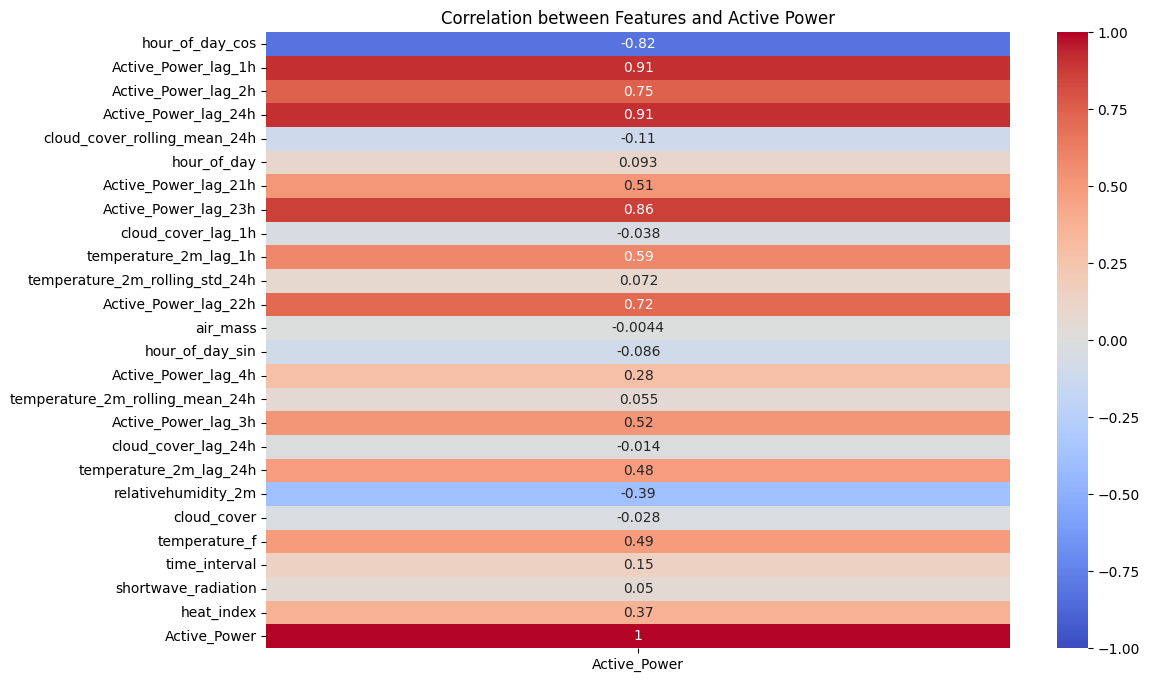

In [80]:
corr_matrix = new_stand_train[features_importance_mahindra[:25]+['Active_Power']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[[target_variable]], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Features and Active Power')
plt.show()

In [81]:
corr_matrix['Active_Power']

,Active_Power
hour_of_day_cos,-0.820244
Active_Power_lag_1h,0.909881
Active_Power_lag_2h,0.745119
Active_Power_lag_24h,0.912669
cloud_cover_rolling_mean_24h,-0.105245
hour_of_day,0.093443
Active_Power_lag_21h,0.508759
Active_Power_lag_23h,0.860567
cloud_cover_lag_1h,-0.038034
temperature_2m_lag_1h,0.585809


In [82]:
# X_train = X_train_df[:'2024-07-30']
# y_train = y_train_df[:'2024-07-30']
# X_val = X_train_df['2024-07-30':]
# y_val = y_train_df['2024-07-30':]

# yulara

In [83]:
# X_train = X_train_df_top25[:'2024-10-25']
# y_train = y_train_df[:'2024-10-25']
# X_val = X_train_df_top25['2024-10-25':]
# y_val = y_train_df['2024-10-25':]

# mahindra

In [84]:
X_train = X_train_df_mahindra_top25[:'2024-10-25']
y_train = y_train_df[:'2024-10-25']
X_val = X_train_df_mahindra_top25['2024-10-25':]
y_val = y_train_df['2024-10-25':]

# mahidra

In [85]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [86]:
# dtest = xgb.DMatrix(new_stand_test_mahindra_top25)

In [89]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    "device":"cpu",
}

In [90]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2500,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=500,
    verbose_eval=100
)

[0]	train-rmse:66133.01635	val-rmse:67252.89964
[100]	train-rmse:8762.55743	val-rmse:12012.83524
[200]	train-rmse:5570.00142	val-rmse:12082.22006
[300]	train-rmse:3952.98600	val-rmse:12236.60955
[400]	train-rmse:2785.17233	val-rmse:12293.41396
[500]	train-rmse:2012.79398	val-rmse:12348.31561
[600]	train-rmse:1496.98206	val-rmse:12321.05471
[636]	train-rmse:1353.22240	val-rmse:12333.44136


In [91]:
joblib.dump(model, f'xgb.pkl')

['xgb.pkl']

In [92]:
val_pred = model.predict(dval)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 12333.441521150804


In [93]:
val_pred = val_pred.clip(min=0.0)

In [94]:
y_val.index = pd.to_datetime(y_val.index)

In [95]:
comparison_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': val_pred
})

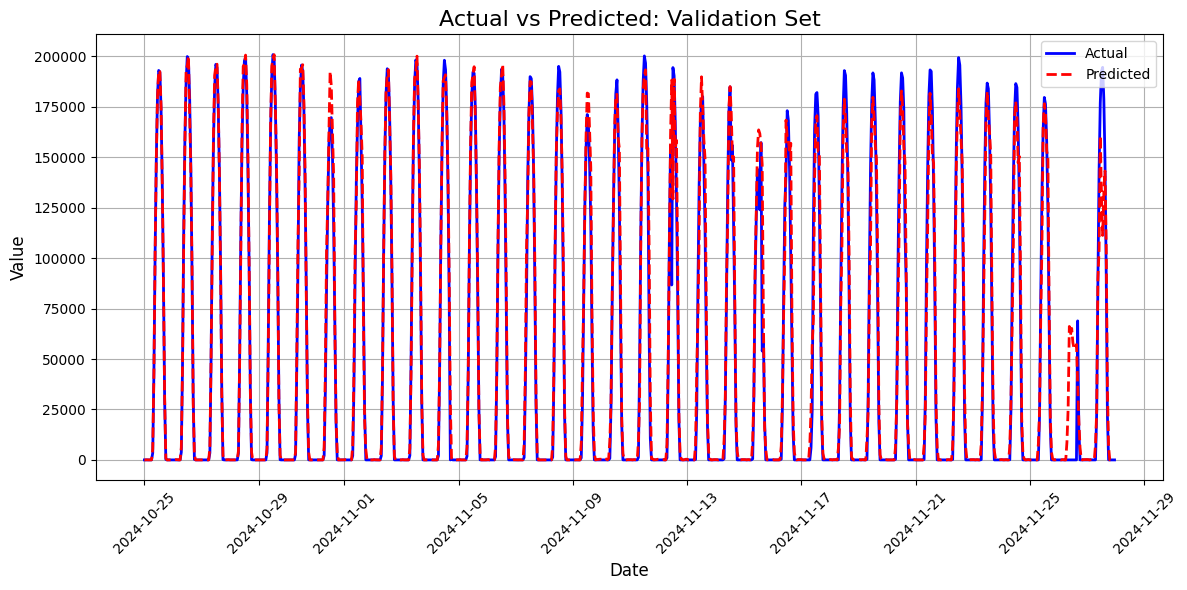

In [96]:
plt.figure(figsize=(12, 6))

plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='blue', linewidth=2)

plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted: Validation Set', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.legend()

plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [97]:
# test_pred = model.predict(dtest)

In [98]:
# test_pred = pd.DataFrame(test_pred)

In [99]:
# test_pred.index = pd.to_datetime(test.index)

In [100]:
# test_pred.loc[(test_pred.index.hour >= 18) | (test_pred.index.hour <= 6), 0] = 0

In [101]:
# test_pred

In [102]:
# test_rmse = mean_squared_error(test.loc['2024-11-11']['Active_Power'],test_pred.loc['2024-11-11'], squared=False)
# test_rmse

In [103]:
# plt.figure(figsize=(12, 6))

# plt.plot(test_pred.index[:500], test['Active_Power'], label='Actual', color='blue', linewidth=2)
# plt.plot(test_pred.index[:500], test_pred[:500], label='Predicted', color='green', linestyle='--', linewidth=2)

# # Add title and labels
# plt.title('Predicted Values for Future Dates', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Predicted Value', fontsize=12)

# # Show the legend
# plt.legend()

# # Show the grid
# plt.grid(True)

# # Display the plot
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Future dates prediction

In [104]:
def detect_time_interval_future(df):
    df_time_detect = df.copy()

    df_time_detect.index = pd.to_datetime(df_time_detect.index)

    intervals = {'first_interval': (6, 9), 'second_interval': (9, 11), 'third_interval': (11, 13),
                'fourth_interval': (13, 15), 'fifth_interval': (15, 17), 'sixth_interval': (17, 20)}

    df_time_detect['time_interval'] = pd.cut(df_time_detect.index.hour, bins=[interval[0] for interval in intervals.values()] + [24],
                                labels=[interval_name for interval_name in intervals.keys()],
                                include_lowest=True, right=False)

    return df_time_detect

In [105]:
def standardize_future_data(new_test,predictor_scaler_fit,encoder):
    X_new_test = new_test[standardize_predictor_list]
    X_new_test = predictor_scaler_fit.transform(X_new_test)
    new_stand_test = pd.DataFrame(X_new_test, index=new_test[standardize_predictor_list].index, columns=new_test[standardize_predictor_list].columns)

    categorical_columns = ['time_interval']
    encoded_features_test = encoder.transform(new_test[categorical_columns])
    encoded_test = pd.DataFrame(encoded_features_test, columns=categorical_columns, index=new_test.index)

    new_stand_test = pd.concat([new_stand_test, encoded_test], axis = 1)

    return new_stand_test

In [106]:
def fetch_future_weather_forecast(latitude, longitude, start_date, num_forecast_steps):
    # Predictors to fetch
    Predictors = [
        'temperature_2m', 'relativehumidity_2m', 'dew_point_2m',
        'surface_pressure', 'cloud_cover', 'wind_speed_10m',
        'wind_direction_10m', 'shortwave_radiation',
        'direct_radiation', 'diffuse_radiation'
    ]

    # Calculate end date based on start date and forecast steps
    end_date = pd.to_datetime(start_date) + pd.Timedelta(hours=num_forecast_steps-1)

    # Fetch forecast
    r = requests.get('https://archive-api.open-meteo.com/v1/archive', params={
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date.strftime('%Y-%m-%d'),
        'hourly': Predictors
    }).json()

    # Create DataFrame
    time = pd.to_datetime(np.array(r['hourly']['time']))
    weather_forecast_df = pd.DataFrame(index=time)

    for p in Predictors:
        weather_forecast_df[p] = np.array(r['hourly'][p])

    # weather_forecast_df = weather_forecast_df.between_time('06:00', '23:00')

    return weather_forecast_df

In [107]:
initial_forecast_data_no_linear = train.tail(24)

# Fetch future weather forecast
start_date = (initial_forecast_data_no_linear.index[-1] + pd.Timedelta(hours=1)).strftime('%Y-%m-%d')

weather_forecast = fetch_future_weather_forecast(
    latitude=28.009465,
    longitude=72.980845,
    start_date=start_date,
    num_forecast_steps=24
)

season_ord = joblib.load("season.pkl")
predictor_scaler_fit = joblib.load("predictor_scaler_fit.pkl")
encoded_features = joblib.load("encoded_features.pkl")

In [108]:
features_list = features_importance_mahindra[:25]

In [109]:
weather_forecast = weather_forecast.reset_index()  # Reset the index
weather_forecast.rename(columns={"index": "date"}, inplace=True)

In [110]:
weather_forecast['date'] = pd.to_datetime(weather_forecast['date'])
weather_forecast = add_season(weather_forecast)
weather_forecast = weather_forecast.set_index('date')
season_train = season_ord.transform(np.array(weather_forecast['season']).reshape(-1,1))
weather_forecast['season'] = season_train
weather_forecast = detect_time_interval(weather_forecast)

In [111]:
weather_forecast['Active_Power']=0.0

In [112]:
def future_forecast(model, num_forecast_steps, features_list,
                    latitude, longitude,altitude, weather_forecast , season_ord , initial_data_no_linear):

    forecast_data_no_linear = initial_data_no_linear.copy()
    weather_forecast_df = weather_forecast.copy()

    future_predictions = []

    for i in range(num_forecast_steps):

        future_data = pd.concat([initial_forecast_data_no_linear,weather_forecast_df])

        forecast_data = nonlinear_features(future_data, latitude, longitude, altitude)

        forecast_data = forecast_data.between_time('06:00', '23:00')

        forecast_data.dropna(inplace=True)

        forecast_data_standard = standardize_future_data(forecast_data,predictor_scaler_fit,encoded_features)

        current_features = forecast_data_standard[features_list].iloc[i:i+1]

        current_hour = forecast_data.index.hour[i]

        if current_hour >= 18 or current_hour <= 6:
            next_prediction = 0.0
        else:
          next_prediction = model.predict(xgb.DMatrix(current_features))[0]
          next_prediction = next_prediction.clip(min=0.0)

        future_predictions.append(next_prediction)

        weather_forecast_df['Active_Power'].iloc[i+6] = next_prediction

    return future_predictions

In [113]:
# Forecast next 18 hours
future_predictions = future_forecast(
    model=model,
    num_forecast_steps=18,
    features_list=features_importance_mahindra[:25],
    latitude=28.009465,
    longitude=72.980845,
    altitude = 217,
    weather_forecast=weather_forecast,
    season_ord = season_ord,
    initial_data_no_linear = initial_forecast_data_no_linear
)

In [114]:
future_predictions

[0.0,
 7521.56103515625,
 32428.671875,
 98121.15625,
 120425.3671875,
 165362.578125,
 179174.0,
 178891.234375,
 164611.78125,
 154558.796875,
 96777.0703125,
 37218.328125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

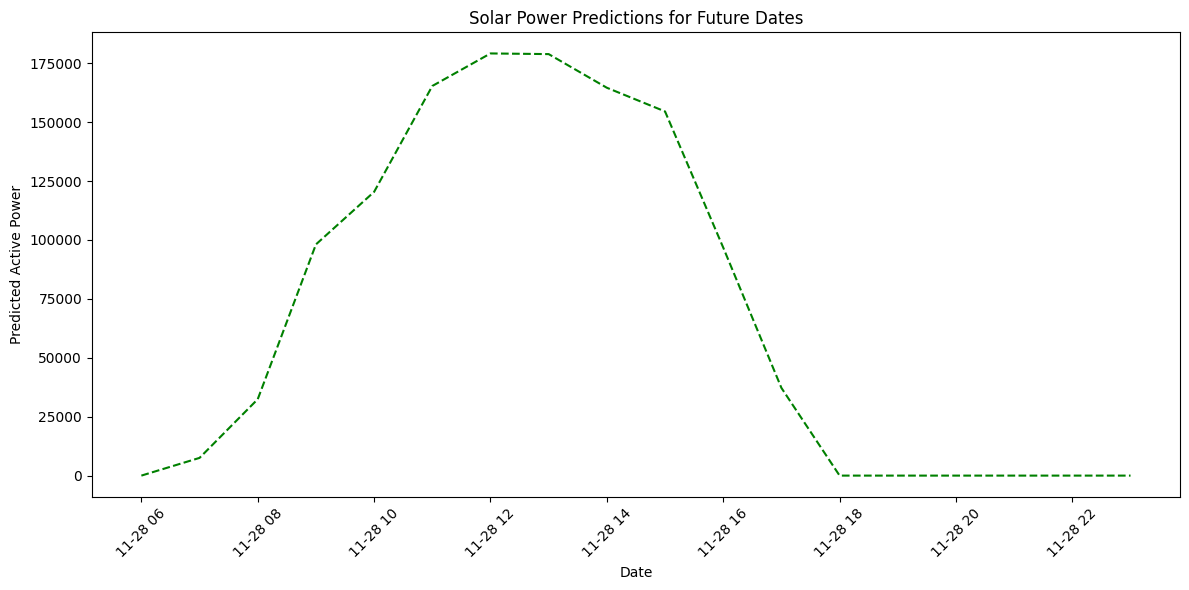

In [115]:
# Convert to DataFrame for visualization
future_dates = pd.date_range(
    start=initial_forecast_data_no_linear.index[-1] + pd.Timedelta(hours=7),
    periods=18,
    freq='H'
)
future_pred_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Power': future_predictions
})

# Visualization
plt.figure(figsize=(12, 6))

# plt.plot(future_pred_df['Date'], test.loc['2024-11-11']['Active_Power'], label='Actual', color='blue', linewidth=2)
plt.plot(future_pred_df['Date'], future_pred_df['Predicted_Power'],
         label='Future Predictions', color='green', linestyle='--')
plt.title('Solar Power Predictions for Future Dates')
plt.xlabel('Date')
plt.ylabel('Predicted Active Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [116]:
# def future_forecast(model, initial_data, num_forecast_steps, features_list,
#                     latitude, longitude,altitude, weather_forecast_df , season_ord , initial_data_no_linear):

#     # Create a copy of the initial data to use for forecasting
#     forecast_data = initial_data.copy()

#     forecast_data_no_linear = initial_data_no_linear.copy()

#     # Initialize list to store predictions
#     future_predictions = []

#     for step in range(num_forecast_steps):
#         # Prepare the input features for prediction
#         current_features = forecast_data[features_list].iloc[-1:]

#         # Check if the current hour is between 18 and 23 (6 PM to 11 PM)
#         current_hour = pd.to_datetime(weather_forecast_df.iloc[step]['date']).hour

#         if current_hour >= 18 or current_hour <= 6:
#             # Set prediction to 0 during evening hours
#             next_prediction = 0.0
#         else:
#             # Predict the next time step
#             # print(pd.DataFrame(current_features))
#             # break
#             next_prediction = model.predict(xgb.DMatrix(current_features))
#             print(next_prediction)
#             break
#             next_prediction = next_prediction.clip(min=0.0)

#         future_predictions.append(next_prediction)

#         new_row = pd.DataFrame(weather_forecast_df.iloc[step]).transpose()

#         # Add the predicted Active Power as a new column
#         new_row['Active_Power'] = next_prediction

#         new_row['date'] = pd.to_datetime(new_row['date'])

#         new_row = add_season(new_row)

#         new_row = new_row.set_index('date')

#         season_train = season_ord.transform(np.array(new_row['season']).reshape(-1,1))

#         new_row['season'] = season_train

#         new_row = detect_time_interval(new_row)

#         forecast_data_no_linear = pd.concat([forecast_data_no_linear,new_row])

#         forecast_data = nonlinear_features(forecast_data_no_linear, latitude, longitude, altitude)

#         forecast_data.fillna(method='bfill', inplace=True)

#         forecast_data = standardize_future_data(forecast_data,predictor_scaler_fit,encoded_features)

#         # print(forecast_data.loc['2024-11-11 06:00:00'][features_list])

#         # break

#     return future_predictions

 98%|===================| 1497/1530 [00:13<00:00]       

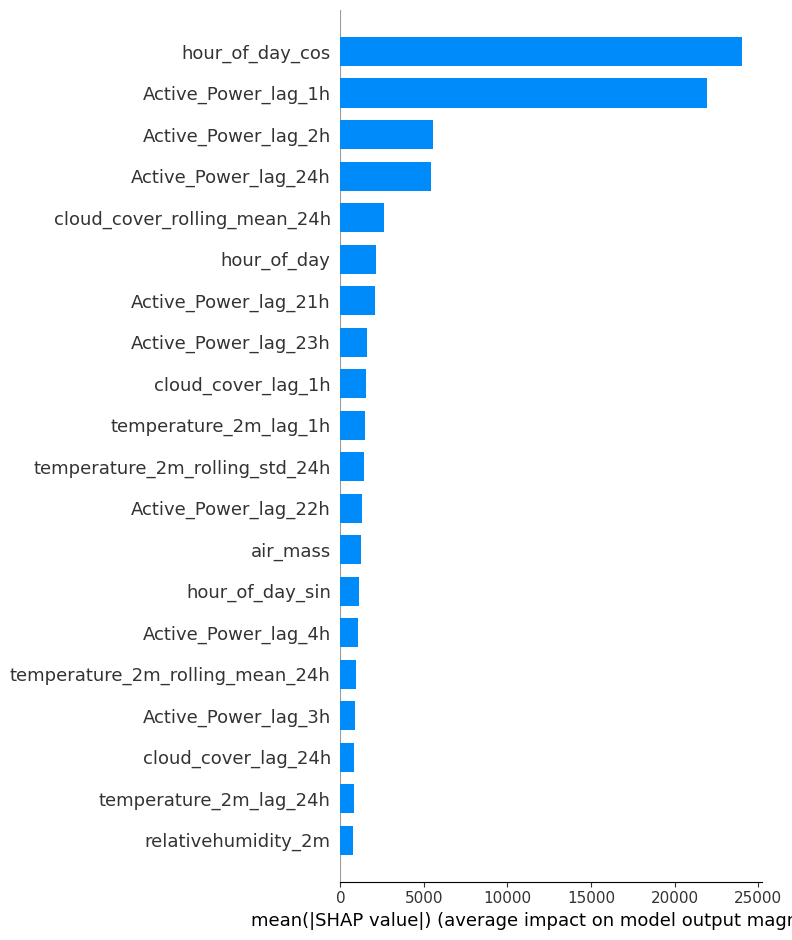

In [ ]:
explainer = shap.TreeExplainer(model,X_train)

shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
# # Detailed summary plot: shows the SHAP value for each feature across all samples
# shap.summary_plot(shap_values, X_train)

# # You can also visualize the impact of a single feature (e.g., 'temperature_2m')
# shap.dependence_plot('temperature_2m', shap_values.values, X_train)

In [ ]:
absolute_mean_shap_values = np.abs(shap_values.values).mean(axis=0)
mean_shap_values = shap_values.values.mean(axis=0)

# Create a dataframe of feature importances
# Get detailed feature impacts
feature_impacts = pd.DataFrame({
    'feature': X_train.columns,
    'mean_shap':mean_shap_values,
    'absolute_mean_shap':absolute_mean_shap_values,
})
# # Get top 25 features
# top_25_features = feature_impacts.sort_values(by='mean_shap', ascending=False).head(25)['feature'].tolist()

In [ ]:
feature_impacts.sort_values(by='absolute_mean_shap', ascending=False)['feature'].tolist()

['hour_of_day_cos',
 'Active_Power_lag_1h',
 'Active_Power_lag_2h',
 'Active_Power_lag_24h',
 'cloud_cover_rolling_mean_24h',
 'hour_of_day',
 'Active_Power_lag_21h',
 'Active_Power_lag_23h',
 'cloud_cover_lag_1h',
 'temperature_2m_lag_1h',
 'temperature_2m_rolling_std_24h',
 'Active_Power_lag_22h',
 'air_mass',
 'hour_of_day_sin',
 'Active_Power_lag_4h',
 'temperature_2m_rolling_mean_24h',
 'Active_Power_lag_3h',
 'cloud_cover_lag_24h',
 'temperature_2m_lag_24h',
 'relativehumidity_2m',
 'cloud_cover',
 'temperature_f',
 'time_interval',
 'shortwave_radiation',
 'heat_index',
 'temperature_2m_change',
 'wind_speed_10m_rolling_std_24h',
 'temp_wind_interaction',
 'wind_speed_10m',
 'solar_zenith_angle',
 'day_of_year_cos',
 'weather_stability_index',
 'wind_chill',
 'dew_point_2m',
 'cloud_cover_change',
 'wind_speed_10m_rolling_mean_24h',
 'THI',
 'surface_pressure',
 'day_of_year',
 'wind_speed_10m_change',
 'cloud_cover_rolling_std_24h',
 'wind_speed_10m_lag_24h',
 'cloud_radiation_

# Negative impact features

In [ ]:
feature_impacts = feature_impacts.sort_values('mean_shap', ascending=False)

negative_impacts = feature_impacts[feature_impacts['mean_shap'] < 0].sort_values('mean_shap')
print("\nFeatures with Negative Impact (sorted by magnitude):")
print(negative_impacts.to_string())


Features with Negative Impact (sorted by magnitude):
                         feature  mean_shap  absolute_mean_shap
1                hour_of_day_cos -16.353582           72.610117
0            Active_Power_lag_1h -11.288394          145.880297
3                    hour_of_day  -6.775459           28.791867
6                hour_of_day_sin  -2.945942           12.840021
9           Active_Power_lag_23h  -1.822925            6.596809
8   cloud_cover_rolling_mean_24h  -1.677909           13.326894
14                 time_interval  -1.472972            8.725363
18                      air_mass  -1.055878            6.234612
19        temperature_2m_lag_24h  -0.702403            6.985982
10          Active_Power_lag_21h  -0.675160            6.686966


### Variations w.r.t
#### a) How earlier data are we training the data on.
#### b) How farther in the future are we predicting

2024-08-25
[0]	train-rmse:56846.67852	val-rmse:69886.90102
[100]	train-rmse:2145.07916	val-rmse:28194.70506
[200]	train-rmse:442.26613	val-rmse:27879.57530
[300]	train-rmse:126.11361	val-rmse:27849.52533
[400]	train-rmse:31.74084	val-rmse:27850.42087
[500]	train-rmse:9.30115	val-rmse:27849.27152
[535]	train-rmse:5.99560	val-rmse:27848.46682
2024-09-10
[0]	train-rmse:59032.66939	val-rmse:71399.42375
[100]	train-rmse:2785.19108	val-rmse:23784.00736
[200]	train-rmse:729.59930	val-rmse:23455.61913
[300]	train-rmse:231.26524	val-rmse:23459.51510
[400]	train-rmse:76.85952	val-rmse:23456.85947
[436]	train-rmse:51.76538	val-rmse:23459.49474
2024-09-25
[0]	train-rmse:62619.63686	val-rmse:70063.02905
[100]	train-rmse:3067.22409	val-rmse:15825.71353
[200]	train-rmse:902.63851	val-rmse:15730.96419
[300]	train-rmse:338.17635	val-rmse:15747.18043
[400]	train-rmse:133.15814	val-rmse:15735.05697
[471]	train-rmse:69.42752	val-rmse:15732.96138
2024-10-10
[0]	train-rmse:64975.52075	val-rmse:68684.46261
[

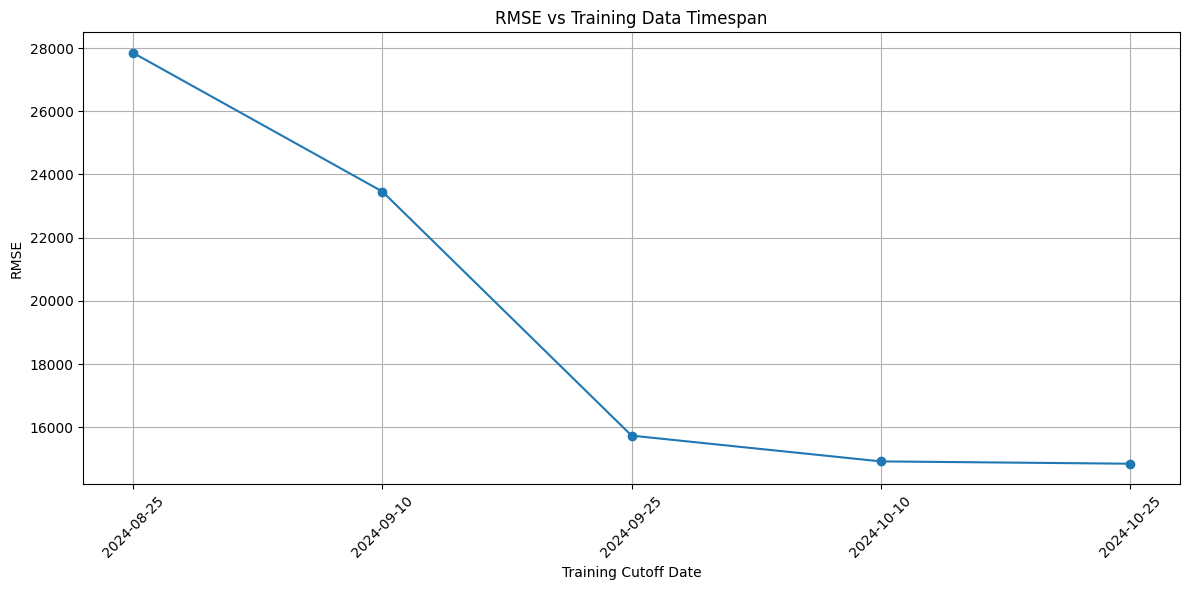

In [125]:
def prepare_data(df, cutoff_date):
    df = df.sort_index()

    # Split data
    X_train = df.loc[:cutoff_date].drop(columns=['Active_Power'])
    y_train = df.loc[:cutoff_date]['Active_Power']
    X_val = df.loc[pd.Timestamp(cutoff_date) + pd.Timedelta(hours=1):].drop(columns=['Active_Power'])
    y_val = df.loc[pd.Timestamp(cutoff_date) + pd.Timedelta(hours=1):]['Active_Power']

    return X_train, y_train, X_val, y_val

def train_xgb_model(X_train, y_train, X_val, y_val):

    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Model parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': 8,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        "device": "cpu"
    }

    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=25000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=250,
        verbose_eval=100
    )

    # Predict and calculate RMSE
    val_pred = model.predict(dval)
    val_pred = val_pred.clip(min=0.0)
    rmse = mean_squared_error(y_val, val_pred, squared=False)

    return model, val_pred, rmse

def analyze_training_timespan_rmse(new_stand_train, features_importance):
    # Select top features
    X_train_df = new_stand_train.drop(columns=['Active_Power'])
    y_train_df = new_stand_train['Active_Power']

    # Define training cutoff dates
    cutoff_dates = [
         '2024-08-25', '2024-09-10' , '2024-09-25', '2024-10-10' , '2024-10-25' ]

    rmse_results = {}

    for cutoff in cutoff_dates:
        # Prepare data'

        print(cutoff)

        X_train, y_train, X_val, y_val = prepare_data(new_stand_train, cutoff)

        # Train model with selected top features
        X_train_top = X_train[features_importance[:25]]
        X_val_top = X_val[features_importance[:25]]

        _, _, rmse = train_xgb_model(X_train_top, y_train, X_val_top, y_val)

        rmse_results[cutoff] = rmse

    return rmse_results

def analyze_prediction_date_rmse(new_stand_test, model,test):

    # Analyze prediction for different test dates
    test_dates = new_stand_test.index[:50]  # First 50 dates in test set
    rmse_results = {}

    for i in range(0, len(test_dates), 5):  # Every 5th date
        X_test = new_stand_test.loc[test_dates[i:i+5]]
        y_test = test.loc[test_dates[i:i+5], 'Active_Power']

        dtest = xgb.DMatrix(X_test)
        test_pred = model.predict(dtest)
        test_pred = test_pred.clip(min=0.0)

        rmse = mean_squared_error(y_test, test_pred, squared=False)
        rmse_results[test_dates[i]] = rmse

    return rmse_results


def visualize_rmse_variation(rmse_results, title, xlabel):

    plt.figure(figsize=(12, 6))

    dates = list(rmse_results.keys())
    rmse_values = list(rmse_results.values())

    plt.plot(dates, rmse_values, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# # Uncomment and modify the following lines to run the analysis
training_rmse = analyze_training_timespan_rmse(new_stand_train, features_importance_mahindra)
visualize_rmse_variation(training_rmse, 'RMSE vs Training Data Timespan', 'Training Cutoff Date')

In [123]:
# prediction_rmse = analyze_prediction_date_rmse(new_stand_test_top25,model,test)
# visualize_rmse_variation(prediction_rmse, 'RMSE vs Prediction Dates', 'Prediction Date')














































## LSTM

In [ ]:
# Scaling the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

In [ ]:
def create_sequences(data,target,time_steps=12):
  X,y = [],[]
  for i in range(len(data)-time_steps):
    X.append(data[i:(i+time_steps),:])
    y.append(target[i+time_steps])
  return np.array(X),np.array(y)

In [ ]:
time_steps = 12
X_train_seq , y_train_seq = create_sequences(X_train_scaled,y_train_scaled,time_steps)
X_val_seq ,y_val_seq = create_sequences(X_val_scaled,y_val_scaled,time_steps)

# Reshaping input to [samples, time_steps, features]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], X_val_seq.shape[1], X_val_seq.shape[2]))

In [ ]:
# Hyperparameters
lstm_units = [128, 64, 32]
dropout_rate = 0.2
l1_factor = 1e-5
l2_factor = 1e-4

# Building the advanced LSTM model
model = tf.keras.Sequential([
    # First Bidirectional LSTM layer with regularization
    Bidirectional(LSTM(lstm_units[0],
                      return_sequences=True,
                      kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor),
                      recurrent_regularizer=l1_l2(l1=l1_factor, l2=l2_factor),
                      input_shape=(time_steps, X_train_seq.shape[2]))),
    BatchNormalization(),
    Dropout(dropout_rate),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(lstm_units[1],
                      return_sequences=True,
                      kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor),
                      recurrent_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))),
    BatchNormalization(),
    Dropout(dropout_rate),

    # Third Bidirectional LSTM layer
    Bidirectional(LSTM(lstm_units[2],
                      kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor),
                      recurrent_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))),
    BatchNormalization(),
    Dropout(dropout_rate),

    # Dense layers for final predictions
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    BatchNormalization(),
    Dropout(dropout_rate/2),
    Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dense(1)  # Output layer
])

# Compile with advanced optimizer settings
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True
)

model.compile(
    optimizer=optimizer,
    loss='huber',  # More robust to outliers than MSE
    metrics=['mae', 'mse']
)

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min'
    )
]

# Training parameters
batch_size = 32
epochs = 30

# Model training
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - loss: 0.3093 - mae: 0.2325 - mse: 0.1491 - val_loss: 0.1378 - val_mae: 0.0957 - val_mse: 0.0253 - learning_rate: 0.0010
Epoch 2/30
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.1110 - mae: 0.0781 - mse: 0.0122 - val_loss: 0.0724 - val_mae: 0.0928 - val_mse: 0.0215 - learning_rate: 0.0010
Epoch 3/30
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.0593 - mae: 0.0703 - mse: 0.0107 - val_loss: 0.0489 - val_mae: 0.0912 - val_mse: 0.0244 - learning_rate: 0.0010
Epoch 4/30
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0382 - mae: 0.0663 - mse: 0.0099 - val_loss: 0.0366 - val_mae: 0.0940 - val_mse: 0.0234 - learning_rate: 0.0010
Epoch 5/30
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0278 - mae: 0.0655 - mse: 0.0096 - val_loss: 0.0288 - val_mae: 0.0884 - val_mse: 0.0217 - learning_rate: 0.0010
Epoch 6/30
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0214 - mae: 0.0635 - mse: 0.0093 - val_loss:

In [ ]:
val_pred_scaled = model.predict(X_val_seq)
val_pred = scaler_y.inverse_transform(val_pred_scaled)
y_val_inverse = scaler_y.inverse_transform(y_val_seq)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


In [ ]:
rmse = np.sqrt(mean_squared_error(y_val_inverse,val_pred))
print(f"Validation RMSE: {rmse}")

Validation RMSE: 199.18233050673132


In [ ]:
# Creating comparison DataFrame for visualization
comparison_df = pd.DataFrame({
    'Actual': y_val_inverse.flatten(),
    'Predicted': val_pred.flatten()
}, index=y_val.index[-len(y_val_inverse):]) # Adjust index length to match data

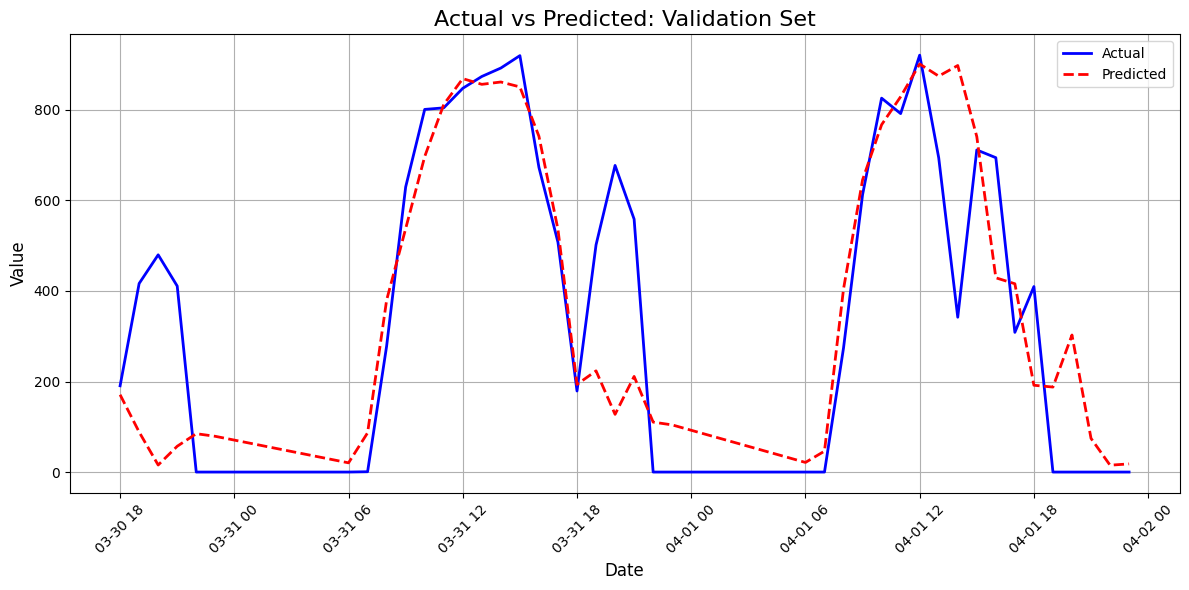

In [ ]:
# Plotting Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='blue', linewidth=2)
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted: Validation Set', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# # Predictions on the test set
# X_test_scaled = scaler_X.transform(new_stand_test)  # Ensure new_stand_test is prepared correctly
# X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# # Make predictions
# test_pred_scaled = model.predict(X_test_seq)

# # Invert scaling for test predictions
# test_pred = scaler_y.inverse_transform(test_pred_scaled)

# # Convert predictions to DataFrame
# test_pred_df = pd.DataFrame(test_pred, index=pd.to_datetime(new_stand_test.index), columns=['Predicted'])

In [ ]:
# # Plotting predictions for future dates
# plt.figure(figsize=(12, 6))
# plt.plot(test_pred_df.index[:50], test_pred_df[:50], label='Predicted', color='green', linestyle='--', linewidth=2)
# plt.title('Predicted Values for Future Dates', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Predicted Value', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## NBeats

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # Load the data
# X_train = X_train
# y_train = y_train
# X_val = X_val
# y_val = y_val

# # Reshape the data for the N-BEATS model
# X_train_reshape = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_val_reshape = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])

# # Define the N-BEATS model
# class NBeatsNet(tf.keras.Model):
#     def __init__(self, backcast_length, forecast_length, stack_types, nb_blocks_per_stack, nb_neurons, share_weights_in_stack, **kwargs):
#         super(NBeatsNet, self).__init__(**kwargs)
#         self.backcast_length = backcast_length
#         self.forecast_length = forecast_length
#         self.stack_types = stack_types
#         self.nb_blocks_per_stack = nb_blocks_per_stack
#         self.nb_neurons = nb_neurons
#         self.share_weights_in_stack = share_weights_in_stack
#         self.stacks = []
#         for stack_id, stack_type in enumerate(self.stack_types):
#             if stack_type == 'generic':
#                 stack = GenericBlock(self.backcast_length, self.forecast_length, self.nb_blocks_per_stack,
#                                     self.nb_neurons, self.share_weights_in_stack, name=f'stack_{stack_id}')
#             else:
#                 raise ValueError(f'unknown stack_type {stack_type}')
#             self.stacks.append(stack)

#     def call(self, inputs, training=False):
#         backcast = 0
#         forecast = 0
#         for stack in self.stacks:
#             b, f = stack(inputs)
#             backcast += b
#             forecast += f
#         return backcast, forecast

# class GenericBlock(tf.keras.Model):
#     def __init__(self, backcast_length, forecast_length, nb_blocks, nb_neurons, share_weights_in_stack, **kwargs):
#         super(GenericBlock, self).__init__(**kwargs)
#         self.backcast_length = backcast_length
#         self.forecast_length = forecast_length
#         self.nb_blocks = nb_blocks
#         self.nb_neurons = nb_neurons
#         self.share_weights_in_stack = share_weights_in_stack
#         self.blocks = []
#         for block_id in range(self.nb_blocks):
#             if self.share_weights_in_stack:
#                 block = Block(self.backcast_length, self.forecast_length, self.nb_neurons, block_id, name=f'block_{block_id}')
#             else:
#                 block = Block(self.backcast_length, self.forecast_length, self.nb_neurons, None, name=f'block_{block_id}')
#             self.blocks.append(block)

#     def call(self, inputs, training=False):
#         backcast = 0
#         forecast = 0
#         for block in self.blocks:
#             b, f = block(inputs)
#             backcast += b
#             forecast += f
#         return backcast, forecast

# class Block(tf.keras.Model):
#     def __init__(self, backcast_length, forecast_length, nb_neurons, block_id, **kwargs):
#         super(Block, self).__init__(**kwargs)
#         self.backcast_length = backcast_length
#         self.forecast_length = forecast_length
#         self.nb_neurons = nb_neurons
#         self.block_id = block_id
#         self.dense1 = Dense(self.nb_neurons, activation='relu', name=f'dense1_{self.block_id}')
#         self.dense2 = Dense(self.nb_neurons, activation='relu', name=f'dense2_{self.block_id}')
#         self.backcast_layer = Dense(self.backcast_length, name=f'backcast_{self.block_id}')
#         self.forecast_layer = Dense(self.forecast_length, name=f'forecast_{self.block_id}')
#         # Initialize Dropout layers here
#         # self.dropout1 = Dropout(0.2)
#         # self.dropout2 = Dropout(0.2)

#     def call(self, inputs, training=False):
#         x = self.dense1(inputs)
#         # Use the pre-initialized Dropout layers
#         # x = self.dropout1(x, training=training)
#         x = self.dense2(x)
#         # Use the pre-initialized Dropout layers
#         # x = self.dropout2(x, training=training)
#         backcast = self.backcast_layer(x)
#         forecast = self.forecast_layer(x)
#         return backcast, forecast

# # Hyperparameters
# backcast_length = X_train.shape[1]
# forecast_length = 1
# stack_types = ['generic']
# nb_blocks_per_stack = 3
# nb_neurons = 256
# share_weights_in_stack = True

# # Create the model
# model = NBeatsNet(backcast_length, forecast_length, stack_types, nb_blocks_per_stack, nb_neurons, share_weights_in_stack)

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# # Train the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# model.fit(X_train_reshape, y_train, validation_data=(X_val_reshape, y_val), epochs=200, batch_size=32, callbacks=[early_stopping], verbose=1)

# # Evaluate the model
# y_pred = model.predict(X_val_reshape)[1]
# y_pred = y_pred.squeeze()  # Remove the extra dimensions
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Validation RMSE: {rmse}")

Epoch 1/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 147564.1719 - val_loss: 117101.6875
Epoch 2/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 130321.8750 - val_loss: 115788.3906
Epoch 3/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 129576.2422 - val_loss: 121827.6328
Epoch 4/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 129232.3438 - val_loss: 115877.1016
Epoch 5/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 128769.4766 - val_loss: 122110.5000
Epoch 6/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 129543.1719 - val_loss: 114605.0703
Epoch 7/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 130640.4609 - val_loss: 120806.1875
Epoch 8/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 130792.5078 - val_loss: 113467.6484
Epoch 9/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 129683.9219 - val_loss: 115739.6641
Epoch 10/200
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 128614.3438 - val_loss: 119426.4453
Epoch 11/